<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-07%5D%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터셋) [Naver sentiment movie corpus](https://github.com/e9t/nsmc)

# 1) 데이터 준비와 확인

In [ ]:
#!ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


In [ ]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

- id: 유저아이디
- document: 리뷰 텍스트
- label: 긍정/부정 여부 (긍정=1, 부정=0)

In [ ]:
display(train_data)    # 15만개
display(test_data)     # 5만개

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


긍정/부정 레이블 분포

<AxesSubplot:>

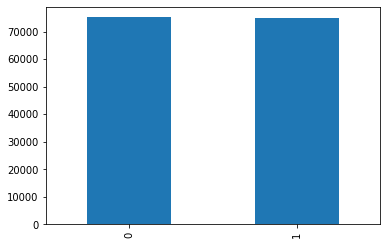

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

# 2) 데이터로더 구성
imdb.data_loader()와 동일하게 동작하는 data_loader를 만든다.
다음과 같은 동작을 수행한다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

다른 형태소 분석기도 고려해보았지만, 너무 오래걸린다.<br>
속도가 압도적으로 제일빠른 Mecab이 적합하다.

In [ ]:
import re
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','과','도','를','으로','자','에','와','한','하다', '이다']

def load_data(train_data, test_data, num_words=10000):
    # 1) 특수기호 및 공백 제거
    train_data['document'] = train_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    #re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', train_data['document'])
    
    train_data['document'] = train_data['document'].str.replace('^ +', "")
    train_data['document'].replace('', np.nan, inplace=True)
    
    # 2) 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)    # subset에 중복데이터를 처리할 칼럼명을 전달
    train_data = train_data.dropna(how = 'any')    # NaN이 있으면 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 3) 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 4) 단어사전 구성
    words = np.concatenate(X_train).tolist() # 단어들을 리스트로 저장
    counter = Counter(words)
    counter = counter.most_common(num_words-4)   # count기준 상위 num_words-4개의 단어로 축소
    #print(counter)
    vocab = ['', '', '', ''] + [key for key, _ in counter]    # 리스트 5번째부터 토큰화한 단어가 count 큰 순으로 저장됨
    #print(vocab)
    word_to_index = {word:index for index, word in enumerate(vocab)}    # 키: 단어, 값: 인덱스(3~num_words-1)
    #print(word_to_index)
    
    # 5) 텍스트 문자열을 사전인덱스 문자열로 변환
    def wordlist_to_indexlist(wordlist):
        # 키==단어이면 단어의 인덱스, 해당하는 단어가 없으면 3
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # X_train 또는 X_test의 모든 원소에 wordlist_to_indexlist함수를 적용시킨 결과들을 리스트로 저장
    # X_train과 X_test는 각 문장에 있는 모든 단어가 담긴 이중리스트였으므로
    # 원래 단어가 있던 곳에 해당하는 인덱스가 들어간 이중리스트가 된다.
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

vocab_size = 30000
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=vocab_size) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


train 데이터

In [ ]:
print(X_train[:10])
print(y_train[:10])

[[27, 68, 894, 33, 216, 15, 28, 701], [997, 483, 494, 639, 4, 112, 1556, 47, 867, 950, 11, 38, 366], [19, 194, 28635], [8034, 145, 4134, 280, 88, 13, 5, 52, 3329], [21628, 8491, 1052, 47, 2701, 55, 4, 2623, 34, 1119, 29, 325, 36, 17, 35, 55, 15312, 21629, 395, 2878, 1677, 5], [628, 21630, 17796, 427, 173, 1465, 663, 1593, 672, 46, 28636, 4, 62, 2169, 120, 723], [239, 352, 8, 356, 1921, 51, 11, 782, 5], [235, 1360, 135, 5, 393, 710, 10358, 15313, 47, 1435, 271, 94, 234, 23, 889, 24, 323, 611, 503, 478, 549, 5, 3168, 8492, 17, 1385, 1385, 67, 284, 13, 5, 47, 97, 7, 70, 17, 28637, 37], [118, 13, 18, 88, 12, 271, 22, 43, 4], [58, 615, 52, 227, 708, 535, 83, 17, 480, 1405, 599, 691, 75, 17, 19, 15314, 12, 15]]
[0 1 0 0 1 0 0 0 1 1]


In [ ]:
len(X_train)

143620

test 데이터

In [ ]:
print(X_test[:10])
print(y_test[:10])

[[805, 130], [3], [81, 111, 52, 3, 3, 898, 316, 38, 30, 3, 40, 600, 3401, 65, 865], [90, 7, 11, 38, 218, 127, 330, 123, 3, 3, 140, 50, 6, 9, 36, 3, 3], [3, 3, 17, 65, 16, 432, 235, 2013, 120, 522, 8, 548, 3, 3, 58, 3, 3, 24, 595, 329, 19691, 794, 7, 10, 7, 278, 3, 3], [223, 50, 148, 3, 53, 223, 4], [580, 99], [1046, 423, 573, 34, 13046, 64, 4707, 1592, 13, 1469, 4089, 173, 3, 5619, 2804, 10, 188], [524, 1231, 43, 637, 4, 221, 7, 6, 82, 13, 26, 2849, 461, 5, 116, 114, 48, 22, 43, 2821, 221, 3, 3, 27, 1334, 5, 16571, 32, 4, 119, 3, 467, 1509, 301, 5], [2801, 1371, 585, 10809, 779, 3017, 3842, 3, 3, 256, 70, 310, 11, 38, 37, 3, 3]]
[1 0 0 0 0 1 0 0 0 1]


In [ ]:
len(X_test)

49157

# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

키: 인덱스, 값: 단어로 가지는 딕셔너리

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{3: '',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '게',
 11: '지',
 12: '있',
 13: '없',
 14: '좋',
 15: '나',
 16: '었',
 17: '만',
 18: '는데',
 19: '너무',
 20: '봤',
 21: '적',
 22: '안',
 23: '정말',
 24: '로',
 25: '것',
 26: '음',
 27: '아',
 28: '네요',
 29: '어',
 30: '지만',
 31: '재밌',
 32: '같',
 33: '진짜',
 34: '에서',
 35: '했',
 36: '기',
 37: '네',
 38: '않',
 39: '거',
 40: '점',
 41: '았',
 42: '수',
 43: '되',
 44: '면',
 45: 'ㅋㅋ',
 46: '인',
 47: '연기',
 48: '말',
 49: '잘',
 50: '주',
 51: '내',
 52: '평점',
 53: '최고',
 54: '이런',
 55: '던',
 56: '어요',
 57: '할',
 58: '왜',
 59: '겠',
 60: '스토리',
 61: '해',
 62: 'ㅋㅋㅋ',
 63: '습니다',
 64: '듯',
 65: '아니',
 66: '생각',
 67: '드라마',
 68: '더',
 69: '그',
 70: '사람',
 71: '싶',
 72: '때',
 73: '감동',
 74: '배우',
 75: '함',
 76: '본',
 77: '까지',
 78: '좀',
 79: '알',
 80: '만들',
 81: '뭐',
 82: '내용',
 83: '볼',
 84: '보다',
 85: '감독',
 86: '라',
 87: '그냥',
 88: '재미',
 89: '시간',
 90: '지루',
 91: '중',
 92: '재미있',
 93: '였',
 94: '년',
 95: '잼',
 96: '사랑',
 97: '못',
 98: '냐',
 99: '쓰레

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[27, 68, 894, 33, 216, 15, 28, 701]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13


In [ ]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(index_to_word[2])
print(index_to_word[3])
#print(index_to_word)

<PAD>
<BOS>
<UNK>
<UNUSED>


In [ ]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 진짜 짜증 나 네요 목소리
라벨:  0


### 데이터셋 내 문장 길이 분포

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 14.020554240356496


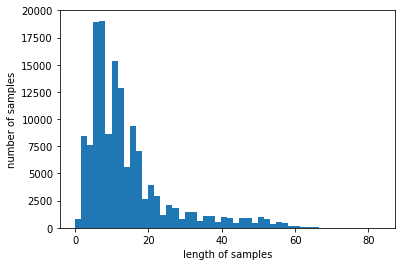

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 최대 문장 길이 지정

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.528138730242716
문장길이 최대 :  105
문장길이 표준편차 :  11.921158321890513
pad_sequences maxlen :  38
전체 문장의 0.9352204879212769가 maxlen 설정값 이내에 포함됩니다. 


### 패딩 추가
padding을 'post'와 'pre'로 모두 해본 결과, 그나마 'post'가 더 나았다.

In [ ]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(143620, 38)


# 4) 모델 구성 및 validation set 구성

모델을 3가지 이상 다양하게 구성하여 실험해보기

## validation 데이터셋 구성

In [ ]:
# validation set 40000건 분리 (약30%)
x_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 약 11만건
partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(103620, 38)
(103620,)


## 1) LSTM (차원=128)

In [ ]:
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

from keras.layers.core import Dropout

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # LSTM레이어. LSTM state 벡터의 차원수는 128로 함. (변경 가능)
# model.add(Dropout(0.2))
# model.add(keras.layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1차원데이터이다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,168,577
Trainable params: 6,168,577
Non-trainable params: 0
_________________________________________________________________


## 2) 1-D CNN: GlobalMaxPooling1D()레이어만 사용

In [ ]:
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         6000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 6,001,617
Trainable params: 6,001,617
Non-trainable params: 0
_________________________________________________________________


## 3) GRU (Gated Reccurent Unit)
GRU도 LSTM과 같은 RNN(순환신경망)으로, 기존 LSTM의 구조를 조금 더 간단하게 개선한 모델이다.

[참고](https://blog.naver.com/winddori2002/221992543837)

In [ ]:
from tensorflow.keras.layers import GRU
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

# 5) 모델 훈련
[Keras - EarlyStopping 주의사항](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=cjh226&logNo=221468928164)

In [ ]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

## 모델1
LSTM레이어를 사용한 모델로 여러 파라미터와 조건을 변경해보며 훈련시켜봤지만, 계속 val_accuracy가 감소한다. 같은 이유로 아래 학습에서 early stop을 한 것이다.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
810/810 [==============================] - 29s 33ms/step - loss: 0.5180 - accuracy: 0.7060 - val_loss: 0.3462 - val_accuracy: 0.8475
Epoch 2/15
810/810 [==============================] - 26s 32ms/step - loss: 0.2882 - accuracy: 0.8802 - val_loss: 0.3401 - val_accuracy: 0.8518
Epoch 3/15
810/810 [==============================] - 23s 28ms/step - loss: 0.2296 - accuracy: 0.9081 - val_loss: 0.3673 - val_accuracy: 0.8502
Epoch 4/15
810/810 [==============================] - 25s 31ms/step - loss: 0.1805 - accuracy: 0.9318 - val_loss: 0.3835 - val_accuracy: 0.8485
Epoch 5/15
810/810 [==============================] - 23s 28ms/step - loss: 0.1456 - accuracy: 0.9451 - val_loss: 0.4602 - val_accuracy: 0.8471
Epoch 6/15
810/810 [==============================] - 25s 31ms/step - loss: 0.1228 - accuracy: 0.9536 - val_loss: 0.5142 - val_accuracy: 0.8406
Epoch 7/15
810/810 [==============================] - 23s 28ms/step - loss: 0.1020 - accuracy: 0.9623 - val_loss: 0.5867 - val_accuracy:

In [ ]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.6053 - accuracy: 0.8311
[0.60526043176651, 0.8310718536376953]


## 모델2
LSTM모델에 비해선 정확도가 어느정도 개선되는 모습을 보였으나, 이 모델 역시 결국 정확도가 다시 낮아져서 early stop되었다. 이전 모델과 하이퍼파라미터의 차이점은 optimizer를 adam에서 rmsprop으로 변경했다는 것이다.

In [ ]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
810/810 [==============================] - 10s 12ms/step - loss: 0.4989 - accuracy: 0.7774 - val_loss: 0.3598 - val_accuracy: 0.8385
Epoch 2/15
810/810 [==============================] - 9s 12ms/step - loss: 0.3371 - accuracy: 0.8558 - val_loss: 0.3505 - val_accuracy: 0.8458
Epoch 3/15
810/810 [==============================] - 10s 12ms/step - loss: 0.3165 - accuracy: 0.8674 - val_loss: 0.3478 - val_accuracy: 0.8479
Epoch 4/15
810/810 [==============================] - 9s 12ms/step - loss: 0.3056 - accuracy: 0.8735 - val_loss: 0.3492 - val_accuracy: 0.8484
Epoch 5/15
810/810 [==============================] - 9s 12ms/step - loss: 0.2950 - accuracy: 0.8790 - val_loss: 0.3493 - val_accuracy: 0.8498
Epoch 6/15
810/810 [==============================] - 10s 12ms/step - loss: 0.2860 - accuracy: 0.8832 - val_loss: 0.3498 - val_accuracy: 0.8503
Epoch 7/15
810/810 [==============================] - 9s 12ms/step - loss: 0.2810 - accuracy: 0.8861 - val_loss: 0.3495 - val_accuracy: 0.8

In [ ]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3632 - accuracy: 0.8408
[0.36318179965019226, 0.8408365249633789]


모델 정의하는 코드를 다시 실행후, 다른 하이퍼파라미터로 학습시켜보자.
- batch_size 축소

In [ ]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 18s 11ms/step - loss: 0.4828 - accuracy: 0.7794 - val_loss: 0.3679 - val_accuracy: 0.8349
Epoch 2/15
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3526 - accuracy: 0.8474 - val_loss: 0.3609 - val_accuracy: 0.8397
Epoch 3/15
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3343 - accuracy: 0.8569 - val_loss: 0.3552 - val_accuracy: 0.8432
Epoch 4/15
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3212 - accuracy: 0.8651 - val_loss: 0.3556 - val_accuracy: 0.8440
Epoch 5/15
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3082 - accuracy: 0.8714 - val_loss: 0.3544 - val_accuracy: 0.8462
Epoch 6/15
1620/1620 [==============================] - 18s 11ms/step - loss: 0.2984 - accuracy: 0.8782 - val_loss: 0.3538 - val_accuracy: 0.8450
Epoch 7/15
1620/1620 [==============================] - 17s 11ms/step - loss: 0.2904 - accuracy: 0.8816 - val_loss: 0.3580 -

In [ ]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3742 - accuracy: 0.8371
[0.3741576373577118, 0.837073028087616]


LSTM모델과 같은 최적화함수 adam를 사용해보자.
- optimizer 변경
- epochs 증가
- early stop의 patience 증가

In [ ]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=7),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=20  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/20
810/810 [==============================] - 19s 23ms/step - loss: 0.4976 - accuracy: 0.7728 - val_loss: 0.3488 - val_accuracy: 0.8459
Epoch 2/20
810/810 [==============================] - 18s 22ms/step - loss: 0.2830 - accuracy: 0.8835 - val_loss: 0.3491 - val_accuracy: 0.8494
Epoch 3/20
810/810 [==============================] - 18s 23ms/step - loss: 0.2106 - accuracy: 0.9203 - val_loss: 0.3755 - val_accuracy: 0.8489
Epoch 4/20
810/810 [==============================] - 18s 22ms/step - loss: 0.1409 - accuracy: 0.9519 - val_loss: 0.4196 - val_accuracy: 0.8432
Epoch 5/20
810/810 [==============================] - 19s 23ms/step - loss: 0.0866 - accuracy: 0.9739 - val_loss: 0.4893 - val_accuracy: 0.8364
Epoch 6/20
810/810 [==============================] - 18s 23ms/step - loss: 0.0516 - accuracy: 0.9856 - val_loss: 0.5584 - val_accuracy: 0.8380
Epoch 7/20
810/810 [==============================] - 18s 23ms/step - loss: 0.0297 - accuracy: 0.9925 - val_loss: 0.6367 - val_accuracy:

In [ ]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7116 - accuracy: 0.8233
[0.7115940451622009, 0.8232805132865906]


## 모델3

In [ ]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [ ]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model3.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [ ]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
810/810 [==============================] - 20s 23ms/step - loss: 0.5933 - accuracy: 0.6266 - val_loss: 0.3522 - val_accuracy: 0.8449
Epoch 2/15
810/810 [==============================] - 17s 21ms/step - loss: 0.3266 - accuracy: 0.8606 - val_loss: 0.3307 - val_accuracy: 0.8535
Epoch 3/15
810/810 [==============================] - 16s 20ms/step - loss: 0.2904 - accuracy: 0.8796 - val_loss: 0.3275 - val_accuracy: 0.8592
Epoch 4/15
810/810 [==============================] - 15s 19ms/step - loss: 0.2610 - accuracy: 0.8930 - val_loss: 0.3228 - val_accuracy: 0.8640
Epoch 5/15
810/810 [==============================] - 17s 21ms/step - loss: 0.2368 - accuracy: 0.9063 - val_loss: 0.3216 - val_accuracy: 0.8591
Epoch 6/15
810/810 [==============================] - 16s 19ms/step - loss: 0.2149 - accuracy: 0.9157 - val_loss: 0.3294 - val_accuracy: 0.8609
Epoch 7/15
810/810 [==============================] - 16s 19ms/step - loss: 0.1961 - accuracy: 0.9235 - val_loss: 0.3434 - val_accuracy:

In [ ]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3930 - accuracy: 0.8392
[0.3930344879627228, 0.8392497301101685]


임베딩 벡터 차원과 batch_size를 축소해보았다.

In [ ]:
from tensorflow.keras.layers import GRU
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 28s 16ms/step - loss: 0.5702 - accuracy: 0.6511 - val_loss: 0.3680 - val_accuracy: 0.8350
Epoch 2/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.3273 - accuracy: 0.8588 - val_loss: 0.3366 - val_accuracy: 0.8533
Epoch 3/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.3024 - accuracy: 0.8715 - val_loss: 0.3434 - val_accuracy: 0.8497
Epoch 4/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2762 - accuracy: 0.8858 - val_loss: 0.3268 - val_accuracy: 0.8594
Epoch 5/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2562 - accuracy: 0.8962 - val_loss: 0.3229 - val_accuracy: 0.8606
Epoch 6/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2311 - accuracy: 0.9084 - val_loss: 0.3509 - val_accuracy: 0.8555
Epoch 7/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2199 - accuracy: 0.9136 - val_loss: 0.3430 -

In [ ]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3922 - accuracy: 0.8452
[0.3921714127063751, 0.8452102541923523]


## 모델3 개선
위의 시도 중 가장 좋은 성능을 보였던 모델에 overfitting을 방지하는 여러 시도를 적용해보자.

### 모델 다시 정의

In [ ]:
from tensorflow.keras.layers import GRU
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model3.add(keras.layers.Dense(1, activation='sigmoid'))

### 모델 학습 및 평가

In [ ]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 28s 16ms/step - loss: 0.5833 - accuracy: 0.6353 - val_loss: 0.3523 - val_accuracy: 0.8453
Epoch 2/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.3333 - accuracy: 0.8574 - val_loss: 0.3330 - val_accuracy: 0.8551
Epoch 3/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2998 - accuracy: 0.8726 - val_loss: 0.3252 - val_accuracy: 0.8561
Epoch 4/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2773 - accuracy: 0.8873 - val_loss: 0.3259 - val_accuracy: 0.8602
Epoch 5/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2528 - accuracy: 0.8993 - val_loss: 0.3267 - val_accuracy: 0.8576
Epoch 6/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2345 - accuracy: 0.9071 - val_loss: 0.3290 - val_accuracy: 0.8601
Epoch 7/15
1620/1620 [==============================] - 26s 16ms/step - loss: 0.2163 - accuracy: 0.9156 - val_loss: 0.3345 -

test데이터에 대한 정확도가 85.09%가 됐다!!

In [ ]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3600 - accuracy: 0.8509
[0.3599618971347809, 0.850906252861023]


위 학습에서 validation accuracy가 가장 높을 때의 모델의 test 정확도를 얻을 수 있다.
<br>
정확도가 85.26%가 나왔다!!

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 7s 4ms/step - loss: 0.3323 - accuracy: 0.8526

 테스트 정확도: 0.8526


# 6) Loss, Accuracy 그래프 시각화

## 모델3 시각화

In [ ]:
history_dict = history3.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


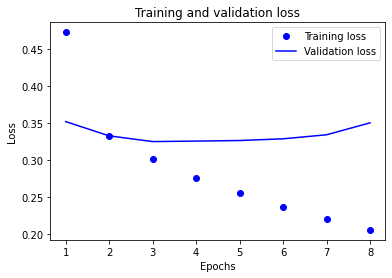

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

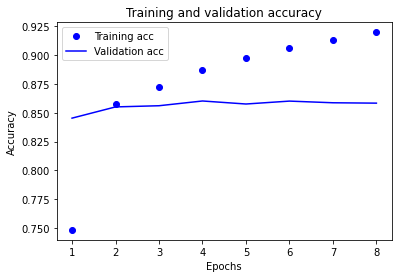

In [ ]:
plt.clf()   # 그림을 초기화합니다
## 모델1 시각화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 8s 4ms/step - loss: 0.3323 - accuracy: 0.8526

 테스트 정확도: 0.8526


하이퍼파라미터인 단어사전의 크기와 임베딩벡터의 크기가 출력된다.

In [ ]:
embedding_layer = loaded_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(30000, 200)


In [ ]:
import os

vocab_size = weights.shape[0]
word_vector_dim = weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = loaded_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 저장한 워드 벡터 다시 로드
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([ 0.06273343, -0.03714864,  0.12566248, -0.13122623,  0.01573539,
       -0.08134139, -0.01717613,  0.03749147, -0.05054217,  0.10172823,
        0.0765738 ,  0.0232986 ,  0.00337438, -0.04466147, -0.06476343,
        0.05054558, -0.13922153,  0.01926111, -0.02169083, -0.11171102,
       -0.0448129 ,  0.06877495,  0.08024184,  0.03578325, -0.11934278,
        0.15652752, -0.07322665,  0.03000994,  0.0307332 , -0.10137568,
       -0.0278828 , -0.04644597, -0.13185091,  0.01239819, -0.09217574,
        0.08648977,  0.03903863,  0.08637027,  0.06404179, -0.07436452,
       -0.049509  ,  0.00937774,  0.00789992, -0.00192053, -0.06893154,
        0.05033013,  0.07289831, -0.084117  ,  0.07574928,  0.04470564,
        0.02019019,  0.04615608,  0.00459643, -0.06636658, -0.03241711,
       -0.08955351, -0.01299446,  0.00854466, -0.01421991,  0.01847629,
       -0.06882796, -0.02002726,  0.07109302, -0.03634397, -0.03022568,
       -0.02729651, -0.06466671,  0.18260902,  0.02061302, -0.10

gensime의 Word2VecKeyedVectors는 한국어에 대해서는 제대로 된 결과를 도출하지 못한다.

In [ ]:
keys = []
for key, distance in word_vectors.similar_by_word('영화'):
    print(key)
    keys.append(word_to_index[key])

는다
닷
잖아
ㅇㅇ
향연
봄
엇다
고
이래
스러워


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
y = tsne.fit_transform(weights)
y.shape

(30000, 2)

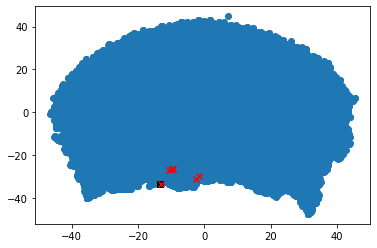

In [ ]:
plt.scatter(y[:,0], y[:,1])
for idx, key in enumerate(keys):            
    if idx == 0:
        plt.scatter(y[key,0], y[key,1], marker='s', c='black')
        continue
    plt.scatter(y[key,0], y[key,1], marker='x', c='r')

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

## 한국어 Word2Vec 임베딩 활용하기
[Pre-trained word vectors of 30+ languages
](https://github.com/Kyubyong/wordvectors)

In [ ]:
import gensim
import os

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [ ]:
word2vec.wv.most_similar('영화')

[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

In [ ]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
from tensorflow.keras.layers import GRU
from keras.layers.core import Dropout
from tensorflow.keras.initializers import Constant

# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(GRU(128))
model4.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 38, 200)           6000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               126720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,126,849
Trainable params: 6,126,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model4.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [ ]:
# 학습의 진행
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
810/810 [==============================] - 20s 23ms/step - loss: 0.6195 - accuracy: 0.6428 - val_loss: 0.3866 - val_accuracy: 0.8260
Epoch 2/15
810/810 [==============================] - 18s 23ms/step - loss: 0.3643 - accuracy: 0.8403 - val_loss: 0.3447 - val_accuracy: 0.8493
Epoch 3/15
810/810 [==============================] - 17s 20ms/step - loss: 0.3030 - accuracy: 0.8716 - val_loss: 0.3245 - val_accuracy: 0.8604
Epoch 4/15
810/810 [==============================] - 18s 22ms/step - loss: 0.2669 - accuracy: 0.8907 - val_loss: 0.3210 - val_accuracy: 0.8633
Epoch 5/15
810/810 [==============================] - 16s 20ms/step - loss: 0.2330 - accuracy: 0.9069 - val_loss: 0.3309 - val_accuracy: 0.8614
Epoch 6/15
810/810 [==============================] - 17s 21ms/step - loss: 0.2023 - accuracy: 0.9208 - val_loss: 0.3294 - val_accuracy: 0.8624
Epoch 7/15
810/810 [==============================] - 16s 20ms/step - loss: 0.1752 - accuracy: 0.9332 - val_loss: 0.3586 - val_accuracy:

In [ ]:
results = model4.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4562 - accuracy: 0.8466
[0.4561851918697357, 0.8465732336044312]


다행히 한국어 word2vec임베딩을 사용하였을 때 정확도가 85.56%로 개선되었다!!

In [ ]:
loaded_model = load_model('best_model4.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 6s 4ms/step - loss: 0.3317 - accuracy: 0.8556

 테스트 정확도: 0.8556


## Loss, Accuracy 시각화

### 한국어 Word2Vec 임베딩을 활용한 모델4

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


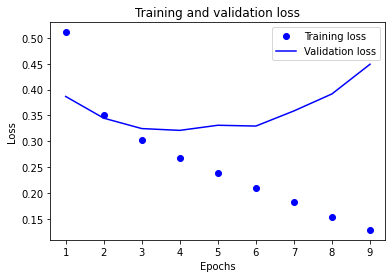

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

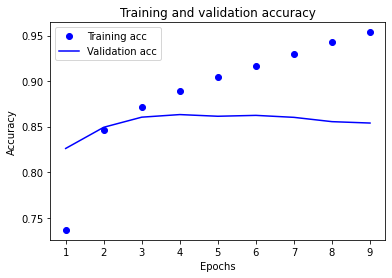

In [ ]:
plt.clf()   # 그림을 초기화합니다
## 모델1 시각화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 루브릭

1.다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
- 상세기준) 3가지 이상의 모델이 성공적으로 시도됨

2.gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
- 상세기준) gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3.한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
- 상세기준) 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

# 회고

이번 문제에서는 overfitting을 어떻게 방지할 것이냐가 모델 성능 개선의 관건이었던 것 같다. 덕분에 Dropout, early stopping 그리고 저번에 해결하지 못한 callbacks도 이제 제대로 이해하고 사용할 수 있게 되었다. callbacks를 통해 학습된 최종 모델이 아니라 학습하면서 가장 성능이 좋았던 것을 기억하는 것이 인상적이었다. 새로운 문장을 입력으로 해서 긍정/부정 분류가 잘 되는지 확인하는 것과 다른 하이퍼파라미터 변경을 통한 모델 성능 차이도 궁금하다.